In [1]:
import os, glob, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

In [2]:
pip install pycatch22

In [3]:
from pycatch22 import catch22_all
from scipy.signal import welch
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    cohen_kappa_score,
    classification_report
)

In [6]:
DATA_DIR = '/content/drive/MyDrive/Stat483-GOALZ/sleepedf_processed'
RESULT_DIR = '/content/drive/MyDrive/Stat483-GOALZ/sleepedf_results'
os.makedirs(RESULT_DIR, exist_ok=True)

In [7]:
print("Files in directory:", os.listdir(DATA_DIR))

Files in directory: ['ST7242J0_sequences.npz', 'ST7242J0_epochs.npz', 'ST7241J0_sequences.npz', 'ST7241J0_epochs.npz', 'ST7221J0_sequences.npz', 'ST7221J0_epochs.npz', 'ST7212J0_sequences.npz', 'ST7212J0_epochs.npz', 'ST7211J0_sequences.npz', 'ST7211J0_epochs.npz', 'ST7202J0_sequences.npz', 'ST7202J0_epochs.npz', 'ST7201J0_sequences.npz', 'ST7201J0_epochs.npz', 'ST7192J0_sequences.npz', 'ST7192J0_epochs.npz', 'ST7191J0_sequences.npz', 'ST7191J0_epochs.npz', 'ST7182J0_sequences.npz', 'ST7182J0_epochs.npz', 'ST7181J0_sequences.npz', 'ST7181J0_epochs.npz', 'ST7172J0_sequences.npz', 'ST7172J0_epochs.npz', 'ST7171J0_sequences.npz', 'ST7171J0_epochs.npz', 'ST7162J0_sequences.npz', 'ST7162J0_epochs.npz', 'ST7161J0_sequences.npz', 'ST7161J0_epochs.npz', 'ST7152J0_sequences.npz', 'ST7152J0_epochs.npz', 'ST7151J0_sequences.npz', 'ST7151J0_epochs.npz', 'ST7142J0_sequences.npz', 'ST7142J0_epochs.npz', 'ST7141J0_sequences.npz', 'ST7141J0_epochs.npz', 'ST7132J0_sequences.npz', 'ST7132J0_epochs.npz',

In [8]:
BATCH_SIZE = 16
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
TRAIN_VAL_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [10]:
EMBEDDING_DIM = 128   # Dimension of the CNN encoder output per epoch
NUM_CLASSES = 5       # 0: Wake, 1: N1, 2: N2, 3: N3, 4: REM
NUM_TRANSFORMER_LAYERS = 2
NUM_HEADS = 4
DROPOUT = 0.1
SEQ_LENGTH = 20       # Number of epochs per sequence (must match preprocessing)

In [11]:
class SleepSequenceDataset(Dataset):
    def __init__(self, data_dir):
        # Find all NPZ files ending with _sequences.npz
        self.files = glob.glob(os.path.join(data_dir, '*_sequences.npz'))
        sequences_list = []
        labels_list = []
        for f in self.files:
            loaded = np.load(f)
            sequences_list.append(loaded['sequences'])  # shape: (n_seq, 20, 2, 3000)
            labels_list.append(loaded['seq_labels'])      # shape: (n_seq, 20)
        self.sequences = np.concatenate(sequences_list, axis=0)
        self.seq_labels = np.concatenate(labels_list, axis=0)
        self.sequences = torch.from_numpy(self.sequences).float()
        self.seq_labels = torch.from_numpy(self.seq_labels).long()

    def __len__(self):
        return self.sequences.shape[0]

    def __getitem__(self, idx):
        return self.sequences[idx], self.seq_labels[idx]

In [ ]:
class MultiScaleEpochEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(MultiScaleEpochEncoder, self).__init__()
        # Branch 1: Kernel size 50
        self.branch1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=50, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8)
        )
        # Branch 2: Kernel size 100
        self.branch2 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=100, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8)
        )
        # Branch 3: Kernel size 150
        self.branch3 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=150, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8)
        )
        # Determine combined output dimension via a dummy forward pass
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 3000)
            out1 = self.branch1(dummy_input)
            out2 = self.branch2(dummy_input)
            out3 = self.branch3(dummy_input)
            # Concatenated features from all three branches:
            n_features = (out1.numel() + out2.numel() + out3.numel()) // dummy_input.shape[0]
        self.fc = nn.Linear(n_features, embedding_dim)

    def forward(self, x):
        # x shape: (batch, 2, 3000)
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        # Flatten outputs
        out1 = out1.view(out1.size(0), -1)
        out2 = out2.view(out2.size(0), -1)
        out3 = out3.view(out3.size(0), -1)
        # Concatenate along the feature dimension
        combined = torch.cat([out1, out2, out3], dim=1)
        embedding = self.fc(combined)
        return embedding

In [12]:
class EpochEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(EpochEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=16, kernel_size=50, stride=6),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=8, stride=8),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        #Passing dummy input to automatically calculate no. of features and avoid mismatch error
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 3000)
            dummy_output = self.net(dummy_input)
            n_features = dummy_output.numel() // dummy_output.shape[0]  # Total features per sample
        self.fc = nn.Linear(n_features, embedding_dim)
        # The output dimension is computed approximately based on the input size 3000
        #self.fc = nn.Linear(32 * (((3000 - 50) // 6 + 1) // 8 // 4), embedding_dim)

    def forward(self, x):
        # x: (batch, 2, 3000)
        out = self.net(x)
        out = out.view(out.size(0), -1)
        embedding = self.fc(out)
        return embedding

In [13]:
class SleepTransformer(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformer, self).__init__()
        self.encoder = EpochEncoder(embedding_dim) #create embeddings using features (catch22) and then add the transformer to it
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        self.seq_length = seq_length

    def forward(self, x):
        # x: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(-1, x.size(2), x.size(3))  # (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)           # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)
        epoch_emb = epoch_emb.transpose(0, 1)   # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # (batch, seq_length, embedding_dim)
        logits = self.classifier(transformer_out)  # (batch, seq_length, num_classes)
        return logits

In [14]:
class SleepTransformerBoosted(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformerBoosted, self).__init__()
        self.encoder = EpochEncoder(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Base classifier (original multi-class head)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        # Additional 1-vs-all classifier head (treats each class as a separate binary problem)
        self.ovr_classifier = nn.Linear(embedding_dim, num_classes)
        # Final classifier that combines transformer features with the 1-vs-all outputs
        self.final_classifier = nn.Linear(embedding_dim + num_classes, num_classes)
        # Residual head for boosting (predicts correction terms)
        self.residual_head = nn.Linear(embedding_dim, num_classes)
        self.seq_length = seq_length

    def forward(self, x):
        # x: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(-1, x.size(2), x.size(3))  # (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)           # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)
        epoch_emb = epoch_emb.transpose(0, 1)   # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # (batch, seq_length, embedding_dim)

        # Base multi-class prediction (could be used as an independent output)
        base_logits = self.classifier(transformer_out)  # (batch, seq_length, num_classes)

        # 1-vs-all predictions: treat each class as a separate binary classifier
        ovr_logits = self.ovr_classifier(transformer_out)  # (batch, seq_length, num_classes)

        # Combine transformer features with one-vs-all outputs
        combined_features = torch.cat([transformer_out, ovr_logits], dim=-1)  # (batch, seq_length, embedding_dim + num_classes)
        final_base_logits = self.final_classifier(combined_features)  # (batch, seq_length, num_classes)

        # Residual fitting: learn to predict the residual error
        residual_logits = self.residual_head(transformer_out)  # (batch, seq_length, num_classes)

        # Final boosted logits: sum the base predictions and the residual corrections
        final_logits = final_base_logits + residual_logits

        return final_logits

In [15]:
class SleepTransformerTargeted(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length):
        super(SleepTransformerTargeted, self).__init__()
        self.encoder = EpochEncoder(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Base multi-class classifier head (for all classes)
        self.classifier = nn.Linear(embedding_dim, num_classes)
        # Additional one-vs-all classifier head for N1 only (outputs a scalar per epoch)
        self.ovr_n1_classifier = nn.Linear(embedding_dim, 1)
        # Residual head for boosting targeted on N1 (predicts a correction term)
        self.n1_residual_head = nn.Linear(embedding_dim, 1)
        self.seq_length = seq_length

    def forward(self, x):
        # x shape: (batch, seq_length, 2, 3000)
        batch_size, seq_len = x.size(0), x.size(1)
        # Process each epoch separately through the CNN encoder:
        x = x.view(-1, x.size(2), x.size(3))  # shape: (batch*seq_length, 2, 3000)
        epoch_emb = self.encoder(x)            # shape: (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)  # shape: (batch, seq_length, embedding_dim)

        # Process sequence with the Transformer:
        epoch_emb = epoch_emb.transpose(0, 1)  # shape: (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(epoch_emb)
        transformer_out = transformer_out.transpose(0, 1)  # shape: (batch, seq_length, embedding_dim)

        # Base classifier outputs multi-class logits:
        base_logits = self.classifier(transformer_out)  # shape: (batch, seq_length, num_classes)

        # Compute targeted one-vs-all output for N1 (class index 1)
        n1_ovr = self.ovr_n1_classifier(transformer_out)  # shape: (batch, seq_length, 1)
        # Compute residual correction for N1
        n1_residual = self.n1_residual_head(transformer_out)  # shape: (batch, seq_length, 1)

        # Add the extra N1 output (one-vs-all + residual) to the base logit for N1
        final_logits = base_logits.clone()
        # Assuming class 1 corresponds to N1
        final_logits[:, :, 1:2] = final_logits[:, :, 1:2] + n1_ovr + n1_residual

        return final_logits


In [16]:
class SleepTransformerFeatureTargeted(nn.Module):
    def __init__(self, embedding_dim, num_classes, num_layers, num_heads, dropout, seq_length,
                 catch22_emb_dim=32, power_emb_dim=16):
        super(SleepTransformerFeatureTargeted, self).__init__()
        self.encoder = EpochEncoder(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # Combined feature dimension: transformer output + catch22 embedding + power embedding
        combined_feature_dim = embedding_dim + catch22_emb_dim + power_emb_dim
        self.combined_classifier = nn.Linear(combined_feature_dim, num_classes)
        # Targeted one-vs-all classifier head for N1 (class index 1)
        self.ovr_n1_classifier = nn.Linear(embedding_dim, 1)
        # Residual head for boosting targeted on N1
        self.n1_residual_head = nn.Linear(embedding_dim, 1)
        # Fully connected layer for catch22 features (maps 22 features to catch22_emb_dim)
        self.catch22_fc = nn.Linear(22, catch22_emb_dim)
        # Fully connected layer for power/spectral features (maps 3 features to power_emb_dim)
        self.power_fc = nn.Linear(3, power_emb_dim)
        self.seq_length = seq_length

    def compute_catch22_features(self, epoch):
        """
        Compute catch22 features for one epoch.
        epoch: Tensor of shape (channels, time)
        Uses the first channel.
        """
        epoch_np = epoch[0].detach().cpu().numpy()  # primary channel
        features = catch22_all(epoch_np)['values']    # returns 22 features
        features = torch.tensor(features, dtype=torch.float, device=epoch.device)
        return features  # shape: (22,)

    def compute_power_spectral_features(self, epoch, fs=100):
        """
        Compute power and spectral density features for one epoch.
        epoch: Tensor of shape (channels, time)
        Uses the first channel.
        Returns a numpy array with [total_power, peak_frequency, mean_frequency].
        """
        epoch_np = epoch[0].detach().cpu().numpy()
        f, Pxx = welch(epoch_np, fs=fs, nperseg=256)
        total_power = np.sum(Pxx)
        peak_freq = f[np.argmax(Pxx)]
        mean_freq = np.sum(f * Pxx) / (total_power + 1e-9)
        return np.array([total_power, peak_freq, mean_freq], dtype=np.float32)

    def forward(self, x):
        """
        x: Tensor of shape (batch, seq_length, channels, 3000)
        """
        batch_size, seq_len, channels, time = x.size()
        # Keep a copy of the raw input for classical feature extraction
        raw_x = x.clone()

        # Process epochs through the CNN encoder
        x_reshaped = x.view(-1, channels, time)  # (batch*seq_length, channels, time)
        epoch_emb = self.encoder(x_reshaped)       # (batch*seq_length, embedding_dim)
        epoch_emb = epoch_emb.view(batch_size, seq_len, -1)  # (batch, seq_len, embedding_dim)

        # Process the sequence with the Transformer
        transformer_in = epoch_emb.transpose(0, 1)      # (seq_length, batch, embedding_dim)
        transformer_out = self.transformer(transformer_in)  # (seq_length, batch, embedding_dim)
        transformer_out = transformer_out.transpose(0, 1)   # (batch, seq_len, embedding_dim)

        # Compute catch22 and power/spectral features for each epoch
        catch22_features = []
        power_features = []
        for b in range(batch_size):
            seq_catch22 = []
            seq_power = []
            for t in range(seq_len):
                epoch = raw_x[b, t]  # shape: (channels, time)
                # Catch22 features (22-dimensional)
                features_c22 = self.compute_catch22_features(epoch)
                seq_catch22.append(features_c22)
                # Power and spectral features (3-dimensional)
                features_power = self.compute_power_spectral_features(epoch)
                features_power = torch.tensor(features_power, dtype=torch.float, device=x.device)
                seq_power.append(features_power)
            seq_catch22 = torch.stack(seq_catch22, dim=0)  # (seq_length, 22)
            seq_power = torch.stack(seq_power, dim=0)      # (seq_length, 3)
            catch22_features.append(seq_catch22)
            power_features.append(seq_power)
        catch22_features = torch.stack(catch22_features, dim=0)  # (batch, seq_length, 22)
        power_features = torch.stack(power_features, dim=0)      # (batch, seq_length, 3)

        # Map catch22 and power features to their embeddings
        catch22_emb = self.catch22_fc(catch22_features)  # (batch, seq_length, catch22_emb_dim)
        power_emb = self.power_fc(power_features)        # (batch, seq_length, power_emb_dim)

        # Concatenate transformer output with catch22 and power embeddings
        combined_features = torch.cat([transformer_out, catch22_emb, power_emb], dim=-1)  # (batch, seq_length, combined_feature_dim)

        # Final combined classifier for all classes
        combined_logits = self.combined_classifier(combined_features)  # (batch, seq_length, num_classes)

        # Targeted one-vs-all and residual for N1 (using transformer output)
        n1_ovr = self.ovr_n1_classifier(transformer_out)      # (batch, seq_length, 1)
        n1_residual = self.n1_residual_head(transformer_out)    # (batch, seq_length, 1)

        # Apply targeted corrections only to the N1 logit (assuming class index 1 is N1)
        combined_logits[:, :, 1:2] = combined_logits[:, :, 1:2] + n1_ovr + n1_residual

        return combined_logits


In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for seq, labels in dataloader:
        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(seq)  # (batch, seq_length, num_classes)
        loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * seq.size(0)
        preds = torch.argmax(logits, dim=-1)
        all_preds.append(preds.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, acc

In [18]:
import torch.nn.functional as F

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []  # <--- store probabilities for ROC

    with torch.no_grad():
        for seq, labels in dataloader:
            seq, labels = seq.to(device), labels.to(device)
            logits = model(seq)  # shape: (batch, seq_length, NUM_CLASSES)

            # Compute loss
            loss = criterion(logits.view(-1, NUM_CLASSES), labels.view(-1))
            running_loss += loss.item() * seq.size(0)

            # Predicted classes
            preds = torch.argmax(logits, dim=-1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            # Softmax probabilities for ROC
            probs = F.softmax(logits, dim=-1)  # shape: (batch, seq_length, NUM_CLASSES)
            all_probs.append(probs.cpu().numpy())

    # Convert lists to NumPy arrays
    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds).ravel()    # shape: (N,)
    all_labels = np.concatenate(all_labels).ravel()  # shape: (N,)

    # Flatten probabilities to shape (N, NUM_CLASSES)
    all_probs = np.concatenate(all_probs, axis=0).reshape(-1, NUM_CLASSES)

    acc = accuracy_score(all_labels, all_preds)

    # Now we return 5 items, including val_probs
    return epoch_loss, acc, all_preds, all_labels, all_probs


In [19]:
def plot_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label='Train Acc')
    plt.plot(epochs, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
def plot_confusion(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['W', 'N1', 'N2', 'N3', 'R']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [22]:
from tqdm.notebook import tqdm

In [23]:
def compute_metrics(y_true, y_pred, class_names=None):
    """
    Compute and print various classification metrics.
    y_true, y_pred: 1D numpy arrays of integer class labels.
    class_names: Optional list of class names (e.g. ["W", "N1", "N2", "N3", "REM"]).
    """
    # Overall accuracy
    acc = accuracy_score(y_true, y_pred)

    # F1 scores
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_per_class = f1_score(y_true, y_pred, average=None)

    # Cohen’s Kappa
    kappa = cohen_kappa_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity & Specificity per class
    # (Note: "sensitivity" is the same as "recall" for that class)
    #        "specificity" = TN / (TN + FP)
    # We can compute them from the confusion matrix:
    #    TP = cm[i, i]
    #    FN = sum(cm[i, :]) - cm[i, i]
    #    FP = sum(cm[:, i]) - cm[i, i]
    #    TN = total_sum - (TP + FN + FP)
    total_sum = cm.sum()
    per_class_sens = []
    per_class_spec = []
    for i in range(cm.shape[0]):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = total_sum - (TP + FN + FP)

        sensitivity = TP / (TP + FN + 1e-9)
        specificity = TN / (TN + FP + 1e-9)
        per_class_sens.append(sensitivity)
        per_class_spec.append(specificity)

    # Print classification report
    # This automatically shows precision, recall, F1, and support for each class
    if class_names is not None:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))

    # Organize everything in a dictionary
    metrics_dict = {
        'Accuracy': acc,
        'Macro_F1': f1_macro,
        'F1_per_class': f1_per_class,
        'Cohen_Kappa': kappa,
        'Sensitivity_per_class': per_class_sens,
        'Specificity_per_class': per_class_spec
    }
    return metrics_dict

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_score, class_names=None):
    """
    Plot one-vs-rest ROC curves for each class in a multi-class setting.

    Parameters:
    -----------
    y_true : 1D array-like of shape (N,)
        Ground truth integer labels (0..num_classes-1).
    y_score : 2D array-like of shape (N, num_classes)
        Predicted probabilities for each class (softmax output).
    class_names : list of str, optional
        Class names to display in the legend. Must have length == num_classes.
    """
    n_classes = y_score.shape[1]

    # Binarize the labels for a one-vs-rest ROC
    # e.g. [0,2,1,...] -> [[1,0,0,0,0], [0,0,1,0,0], [0,1,0,0,0], ...]
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    # Compute ROC curve and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(7,7))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'darkgreen']
    for i in range(n_classes):
        if class_names and i < len(class_names):
            label_str = f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
        else:
            label_str = f"Class {i} (AUC = {roc_auc[i]:.2f})"
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2, label=label_str)

    # Plot a random guess line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
dataset = SleepSequenceDataset(DATA_DIR)

In [ ]:
# Load dataset from processed sequence NPZ files
total_len = len(dataset)
train_len = int(TRAIN_VAL_SPLIT * total_len)
val_len = total_len - train_len
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = SleepTransformerFeatureTargeted(EMBEDDING_DIM, NUM_CLASSES, NUM_TRANSFORMER_LAYERS, NUM_HEADS, DROPOUT, SEQ_LENGTH)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(1, NUM_EPOCHS+1), desc="Training Epochs"):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

plot_curves(train_losses, val_losses, train_accs, val_accs)
_, _, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
plot_confusion(val_labels, val_preds)

    # Save the model checkpoint in RESULT_DIR
    #torch.save(model.state_dict(), os.path.join(RESULT_DIR, 'sleep_transformer_model.pth'))

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
_, _, val_preds, val_labels, _ = eval_epoch(model, val_loader, criterion, DEVICE)
metrics_dict = compute_metrics(val_labels, val_preds, class_names=["W","N1","N2","N3","REM"])
print(metrics_dict)


Classification Report:
              precision    recall  f1-score   support

           W     0.8729    0.7509    0.8073       823
          N1     0.6073    0.6955    0.6485       785
          N2     0.8904    0.9228    0.9064      4562
          N3     0.8893    0.9212    0.9050      1447
         REM     0.9204    0.8132    0.8635      1863

    accuracy                         0.8673      9480
   macro avg     0.8361    0.8207    0.8261      9480
weighted avg     0.8712    0.8673    0.8678      9480

{'Accuracy': 0.8672995780590718, 'Macro_F1': 0.8261144394630815, 'F1_per_class': array([0.80731548, 0.64845606, 0.90635091, 0.90495587, 0.86349387]), 'Cohen_Kappa': np.float64(0.8069543781071479), 'Sensitivity_per_class': [np.float64(0.7509113001205943), np.float64(0.6955414012729993), np.float64(0.9228408592720466), np.float64(0.9212163096054449), np.float64(0.8132045088562463)], 'Specificity_per_class': [np.float64(0.9896037888412856), np.float64(0.9594019551465256), np.float64(0.

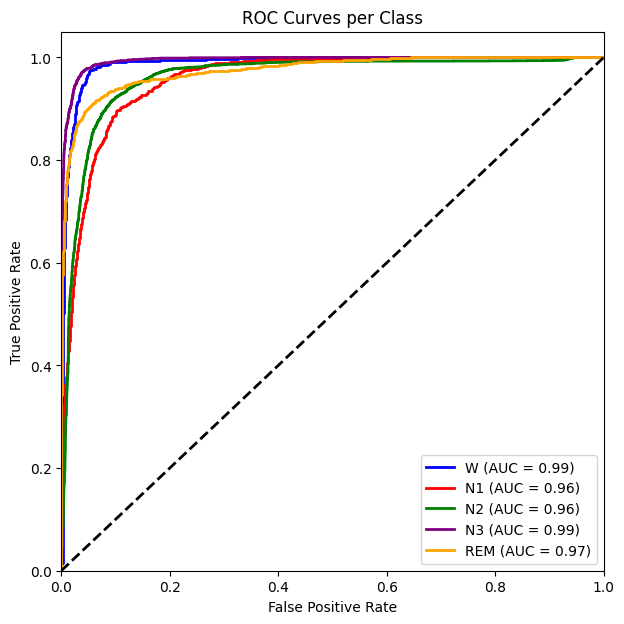

In [50]:
val_loss, val_acc, val_preds, val_labels, val_probs = eval_epoch(
    model, val_loader, criterion, DEVICE
)

plot_roc_curves(val_labels, val_probs, class_names=["W","N1","N2","N3","REM"])